##Penerapan Logistic Regression dan Random Forest untuk Analisis Sentimen Tweet Monkeypox

Pada proyek ini, saya melakukan analisis sentimen terhadap tweet terkait Monkeypox untuk mengidentifikasi bagaimana masyarakat merespons isu kesehatan ini. Dengan memanfaatkan dua model machine learning—Logistic Regression dan Random Forest—kami berhasil mengklasifikasikan tweet menjadi tiga kategori sentimen: positif, negatif, dan netral.

dataset : https://www.kaggle.com/datasets/stephencrone/monkeypox

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import torch.optim as optim

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
plt.style.use('default')
sns.set_theme()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
df = pd.read_csv('/content/monkeypox.csv')
print("Informasi Dataset:")
print(df.info())
print("\nContoh data:")
print(df.head())

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5787 entries, 0 to 5786
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   number            5787 non-null   int64 
 1   created_at        5787 non-null   object
 2   text              5787 non-null   object
 3   source            5787 non-null   object
 4   user is verified  5787 non-null   bool  
 5   user has url      5787 non-null   bool  
 6   user description  5035 non-null   object
 7   user created at   5787 non-null   object
 8   retweet_count     5787 non-null   int64 
 9   reply_count       5787 non-null   int64 
 10  like_count        5787 non-null   int64 
 11  quote_count       5787 non-null   int64 
 12  followers count   5787 non-null   int64 
 13  following count   5787 non-null   int64 
 14  tweet count       5787 non-null   int64 
 15  listed_count      5787 non-null   int64 
 16  user location     3921 non-null   object


Dataset ini berisi 5787 tweet terkait Monkeypox, yang mencakup atribut penting seperti waktu pembuatan, teks tweet, platform sumber, serta informasi pengguna seperti jumlah pengikut, lokasi, dan deskripsi pengguna. Data ini digunakan untuk melakukan analisis sentimen pada tweet tentang Monkeypox.

In [ ]:
# Ambil stopwords bahasa Inggris
stop_words = set(stopwords.words('english'))

# Fungsi preprocessing untuk teks Inggris
def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase
        text = text.lower()

        # Hilangkan URL
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)

        # Hilangkan karakter khusus dan angka
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)

        # Hilangkan spasi berlebih
        text = ' '.join(text.split())

        # Tokenisasi dan hapus stopwords
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]

        return ' '.join(tokens)
    return ''

# Terapkan ke kolom 'text'
print("Melakukan preprocessing teks...")
df['processed_text'] = df['text'].apply(preprocess_text)

# Tampilkan hasil contoh
print("\nContoh Hasil Preprocessing:")
for i in range(5):
    print(f"\nOriginal: {df['text'].iloc[i]}")
    print(f"Processed: {df['processed_text'].iloc[i]}")

Melakukan preprocessing teks...

Contoh Hasil Preprocessing:

Original: Much of the focus on #monkeypox recently has been on how its affecting people in richer countries during this current outbreak. Dr Charles Mahzude spoke to me on #aidsmapLIVE about what we know from West Africa where moneypox is endemic about how it affects people with HIV. _URL_
Processed: much focus monkeypox recently affecting people richer countries current outbreak dr charles mahzude spoke aidsmaplive know west africa moneypox endemic affects people hiv _url_

Original: ICYMI: The first probable case of monkeypox in West Virginia has been identified, state health officials announced Friday. _URL_
Processed: icymi first probable case monkeypox west virginia identified state health officials announced friday _url_

Original: WHO: #Monkeypox outbreak not yet a global public health emergency _URL_ via @statnews #healthcare _URL_
Processed: monkeypox outbreak yet global public health emergency _url_ via statnews he


=== Exploratory Data Analysis ===

Statistik Deskriptif:
            number                     created_at  retweet_count  reply_count  \
count  5787.000000                           5787    5787.000000  5787.000000   
mean   2906.135476  2022-07-09 14:56:35.121997568       2.742872     1.037671   
min       1.000000            2022-07-07 00:29:46       0.000000     0.000000   
25%    1455.500000     2022-07-09 05:53:13.500000       0.000000     0.000000   
50%    2906.000000            2022-07-09 14:38:29       0.000000     0.000000   
75%    4356.500000     2022-07-09 19:48:01.500000       0.000000     1.000000   
max    5810.000000            2022-07-13 23:50:30    2281.000000   550.000000   
std    1676.582323                            NaN      39.652237     9.291639   

         like_count  quote_count  followers count  following count  \
count   5787.000000  5787.000000     5.787000e+03      5787.000000   
mean      13.870918     0.872991     3.678703e+04      1837.514429   
mi

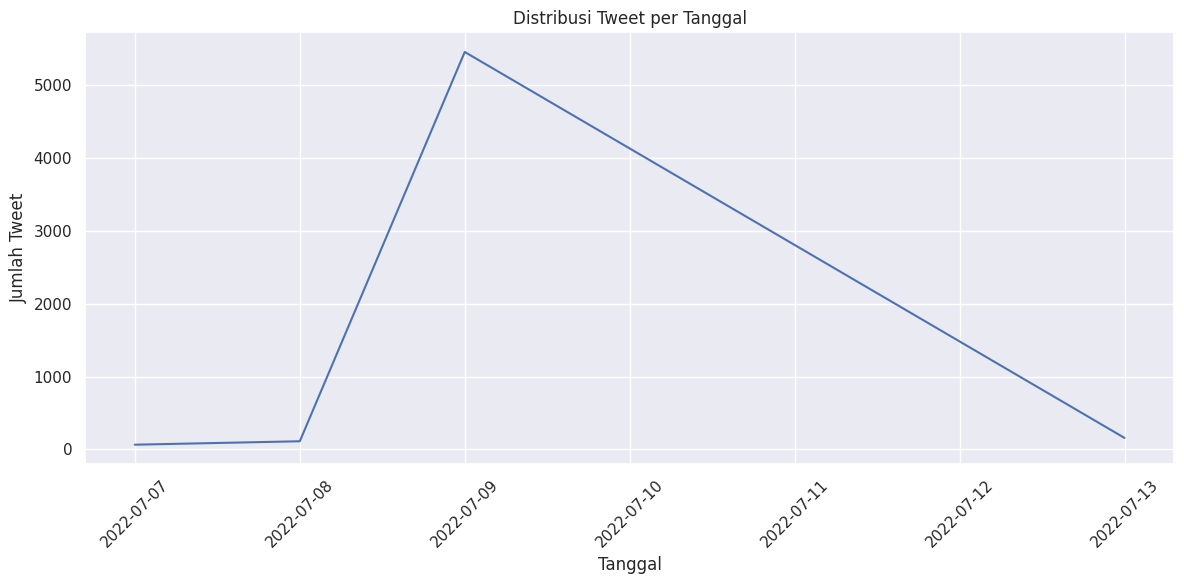

<Figure size 1200x600 with 0 Axes>

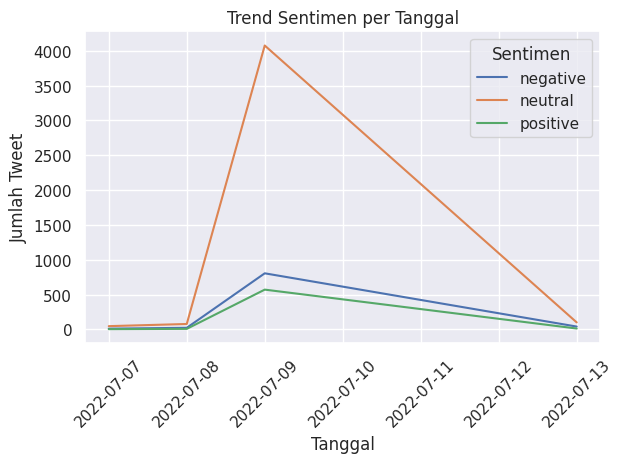

In [ ]:
# === Exploratory Data Analysis (EDA) ===
print("\n=== Exploratory Data Analysis ===")

# 1. Analisis Dasar
print("\nStatistik Deskriptif:")
print(df.describe())

# 2. Analisis Tanggal
df['created_at'] = pd.to_datetime(df['created_at'])

# Plot distribusi tweet per tanggal
plt.figure(figsize=(12, 6))
df['created_at'].dt.date.value_counts().sort_index().plot(kind='line')
plt.title('Distribusi Tweet per Tanggal')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Tweet')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

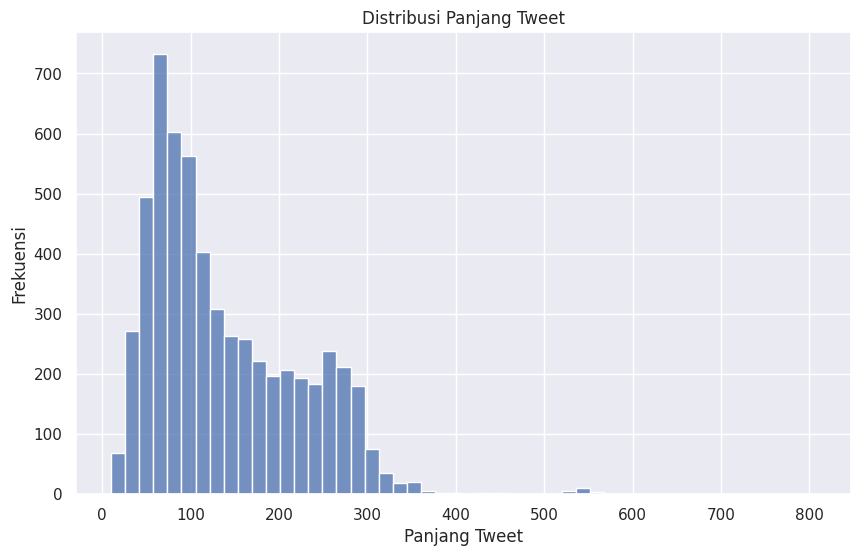


Statistik Panjang Tweet per Sentimen:
            count        mean        std   min     25%    50%     75%    max
sentiment                                                                   
negative    884.0  185.296380  95.885173  33.0  104.00  180.5  250.00  788.0
neutral    4303.0  122.881943  77.746202  10.0   66.00   97.0  165.50  807.0
positive    600.0  179.625000  82.539136  20.0  107.75  173.0  256.25  427.0


In [ ]:
# 3. Analisis Panjang Tweet
df['tweet_length'] = df['text'].str.len()

# Plot distribusi panjang tweet
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tweet_length', bins=50)
plt.title('Distribusi Panjang Tweet')
plt.xlabel('Panjang Tweet')
plt.ylabel('Frekuensi')
plt.show()

# Statistik panjang tweet per sentimen
print("\nStatistik Panjang Tweet per Sentimen:")
print(df.groupby('sentiment')['tweet_length'].describe())

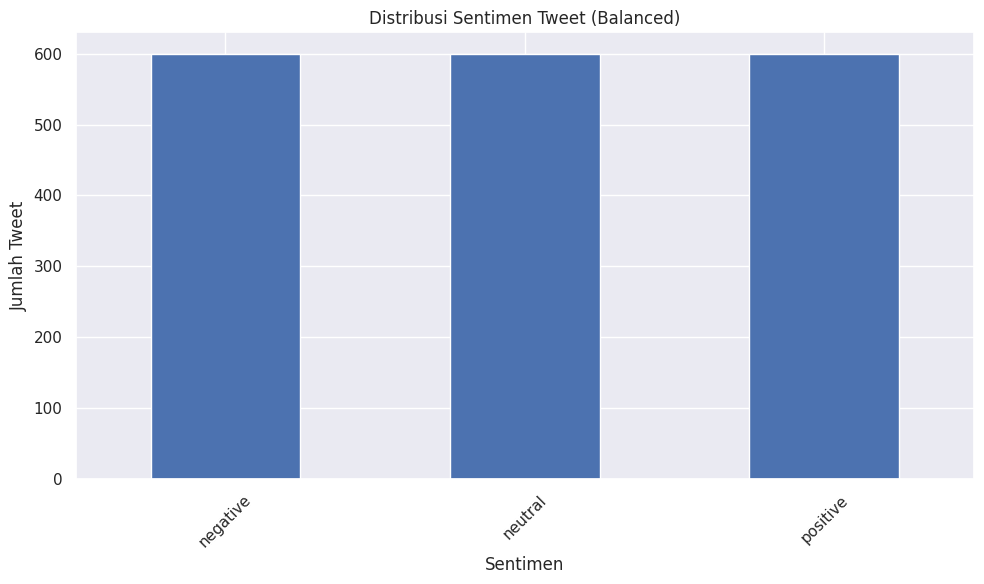

In [ ]:
# 4. Analisis Sentimen dengan Sampling
# Sampling untuk menyeimbangkan data
sample_size = min(df['sentiment'].value_counts())
balanced_df = pd.concat([
    df[df['sentiment'] == sentiment].sample(n=sample_size, random_state=42)
    for sentiment in df['sentiment'].unique()
])

# Plot distribusi sentimen dengan data yang seimbang
plt.figure(figsize=(10, 6))
balanced_df['sentiment'].value_counts().plot(kind='bar')
plt.title('Distribusi Sentimen Tweet (Balanced)')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Tweet')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

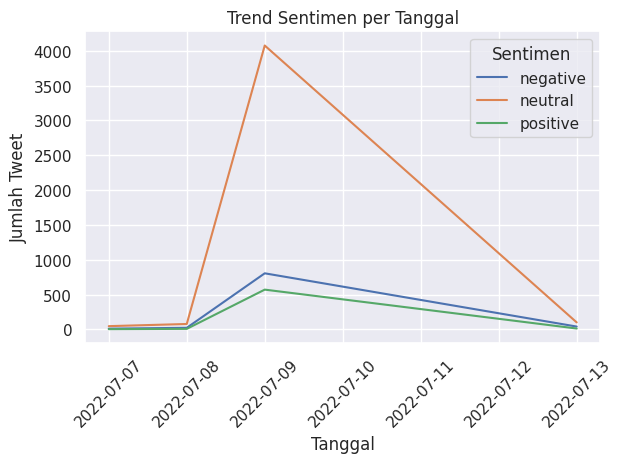

In [ ]:
# 5. Analisis Sentimen per Tanggal
sentiment_by_date = df.groupby([df['created_at'].dt.date, 'sentiment']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
sentiment_by_date.plot(kind='line')
plt.title('Trend Sentimen per Tanggal')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Tweet')
plt.legend(title='Sentimen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Membuat Word Cloud per Sentimen...


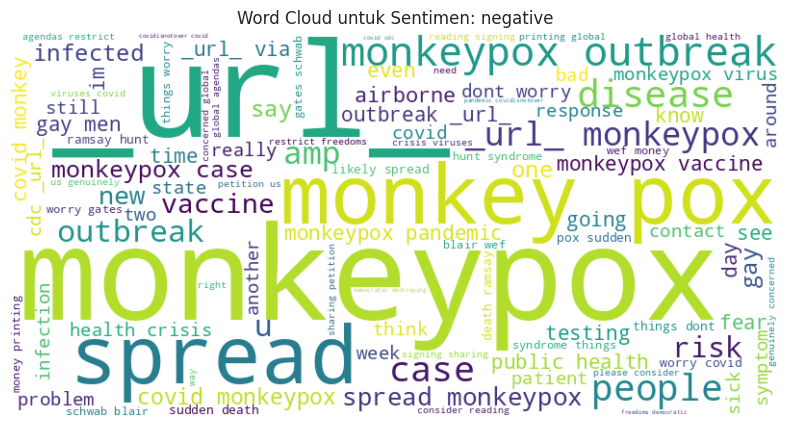

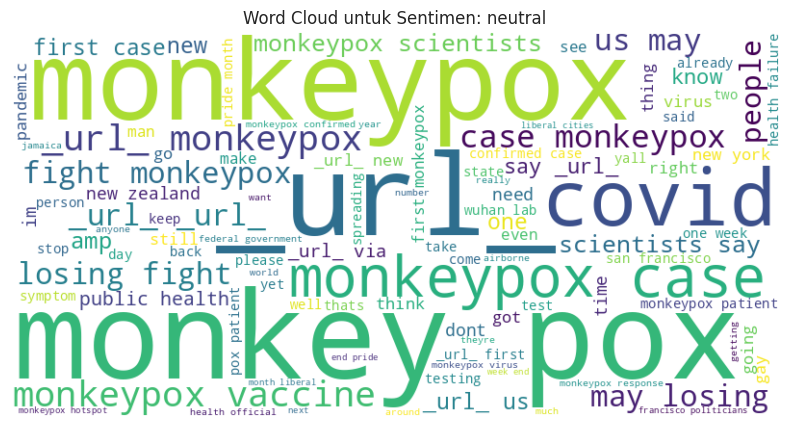

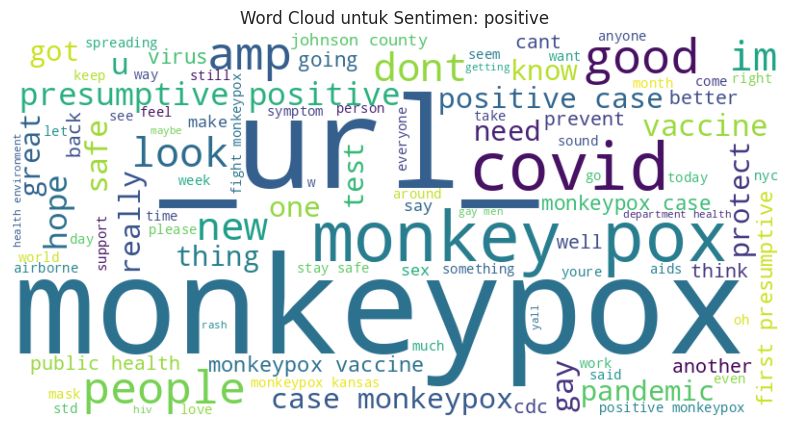


Kata yang Sering Muncul per Sentimen:

Sentimen: negative
[('monkeypox', 783), ('_url_', 532), ('spread', 244), ('outbreak', 230), ('pox', 181), ('covid', 181), ('monkey', 169), ('disease', 125), ('cases', 116), ('health', 106)]

Sentimen: neutral
[('monkeypox', 3363), ('_url_', 2597), ('pox', 1132), ('monkey', 1130), ('cases', 496), ('case', 444), ('vaccine', 419), ('us', 408), ('covid', 382), ('health', 375)]

Sentimen: positive
[('monkeypox', 468), ('like', 290), ('_url_', 285), ('pox', 171), ('monkey', 169), ('covid', 153), ('good', 76), ('positive', 74), ('amp', 64), ('case', 63)]


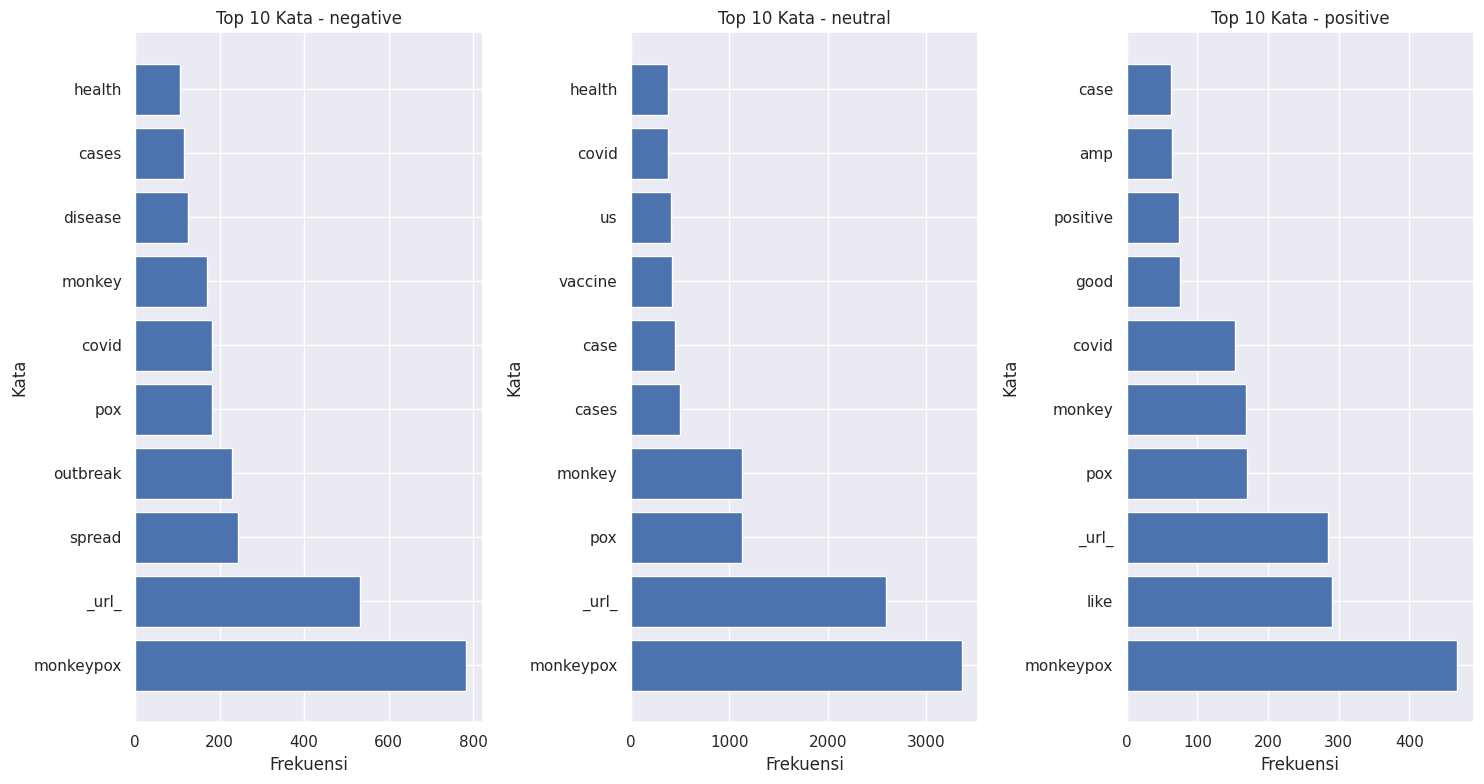

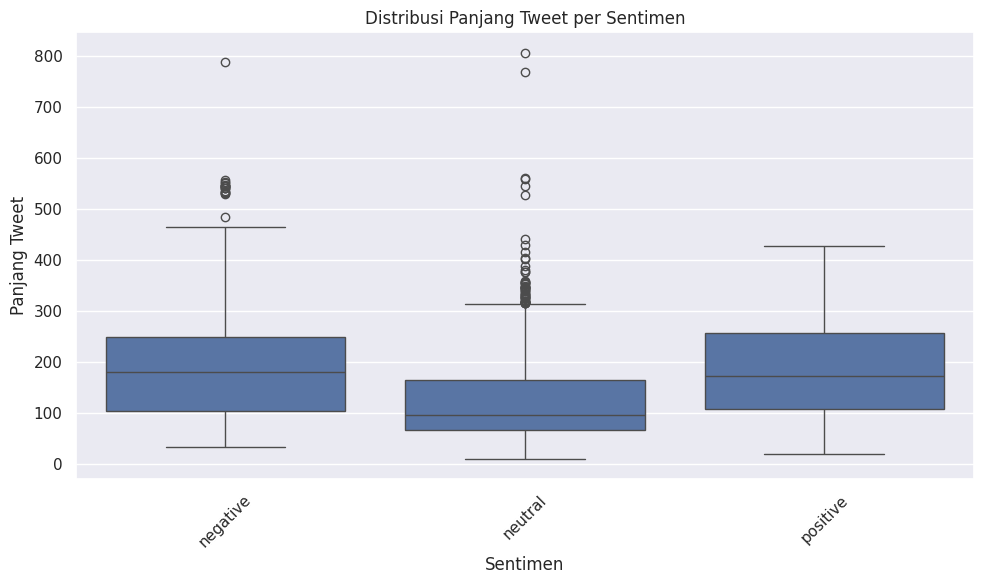


Ringkasan Statistik per Sentimen:
          tweet_length                  text
                  mean    std min  max count
sentiment                                   
negative        185.30  95.89  33  788   884
neutral         122.88  77.75  10  807  4303
positive        179.62  82.54  20  427   600


In [ ]:
# 6. Word Cloud per Sentimen
print("\nMembuat Word Cloud per Sentimen...")
for sentiment in df['sentiment'].unique():
    text = ' '.join(df[df['sentiment'] == sentiment]['processed_text'])
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         max_words=100,
                         colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud untuk Sentimen: {sentiment}')
    plt.show()

# 7. Analisis Kata yang Sering Muncul
def get_top_words(text_series, n=10):
    words = ' '.join(text_series).split()
    return Counter(words).most_common(n)

print("\nKata yang Sering Muncul per Sentimen:")
for sentiment in df['sentiment'].unique():
    print(f"\nSentimen: {sentiment}")
    print(get_top_words(df[df['sentiment'] == sentiment]['processed_text']))

# 8. Visualisasi Distribusi Kata per Sentimen
top_words_by_sentiment = {}
for sentiment in df['sentiment'].unique():
    words = ' '.join(df[df['sentiment'] == sentiment]['processed_text']).split()
    word_counts = Counter(words).most_common(10)
    top_words_by_sentiment[sentiment] = word_counts

plt.figure(figsize=(15, 8))
for i, (sentiment, word_counts) in enumerate(top_words_by_sentiment.items()):
    words, counts = zip(*word_counts)
    plt.subplot(1, 3, i+1)
    plt.barh(words, counts)
    plt.title(f'Top 10 Kata - {sentiment}')
    plt.xlabel('Frekuensi')
    plt.ylabel('Kata')
plt.tight_layout()
plt.show()

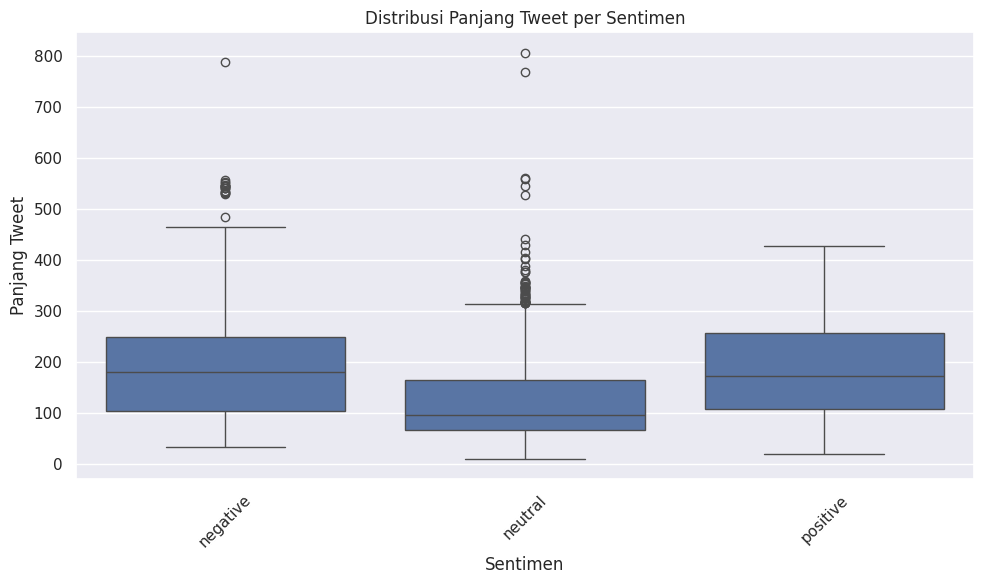

In [ ]:
# 9. Analisis Korelasi Panjang Tweet dengan Sentimen
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='sentiment', y='tweet_length')
plt.title('Distribusi Panjang Tweet per Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Panjang Tweet')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# 10. Ringkasan Statistik
print("\nRingkasan Statistik per Sentimen:")
print(df.groupby('sentiment').agg({
    'tweet_length': ['mean', 'std', 'min', 'max'],
    'text': 'count'
}).round(2))


Ringkasan Statistik per Sentimen:
          tweet_length                  text
                  mean    std min  max count
sentiment                                   
negative        185.30  95.89  33  788   884
neutral         122.88  77.75  10  807  4303
positive        179.62  82.54  20  427   600


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Persiapan Data: Menentukan fitur (X) dan label (y) untuk model
X = df['processed_text']  # Data teks yang sudah diproses
y = df['sentiment']       # Label sentimen (positif, negatif, netral)

# Pembagian Data (Train-Test Split): Membagi data menjadi data latih (80%) dan data uji (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vektorisasi Data menggunakan TF-IDF: Mengubah teks menjadi representasi numerik berbasis frekuensi kata
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # Menggunakan stopwords bahasa Inggris dan membatasi fitur maksimal
X_train_tfidf = vectorizer.fit_transform(X_train)  # Menghitung TF-IDF untuk data latih
X_test_tfidf = vectorizer.transform(X_test)        # Menghitung TF-IDF untuk data uji


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Model Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_tfidf, y_train)

# Model Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)


RandomForestClassifier(random_state=42)

=== Logistic Regression Evaluation ===
Akurasi:  0.8860103626943006
              precision    recall  f1-score   support

    negative       0.95      0.70      0.80       174
     neutral       0.88      0.98      0.93       856
    positive       0.86      0.52      0.64       128

    accuracy                           0.89      1158
   macro avg       0.90      0.73      0.79      1158
weighted avg       0.89      0.89      0.88      1158


=== Random Forest Evaluation ===
Akurasi:  0.9533678756476683
              precision    recall  f1-score   support

    negative       0.95      0.94      0.95       174
     neutral       0.96      0.98      0.97       856
    positive       0.91      0.80      0.85       128

    accuracy                           0.95      1158
   macro avg       0.94      0.91      0.92      1158
weighted avg       0.95      0.95      0.95      1158



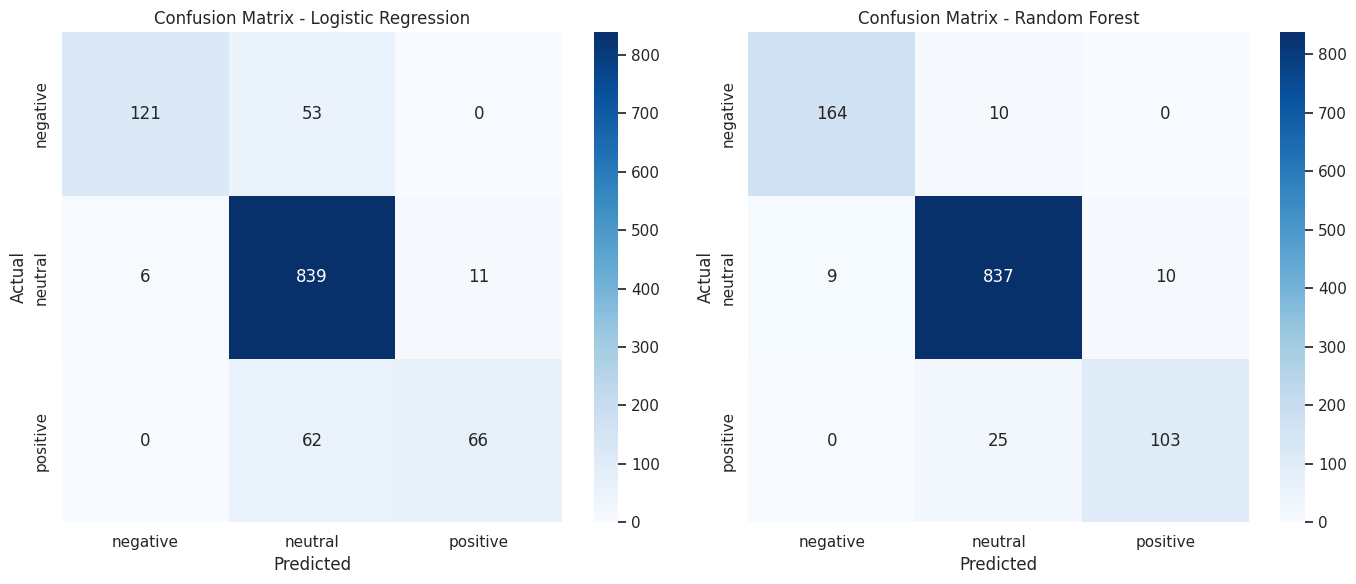

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluasi: Prediksi dan Evaluasi untuk Logistic Regression
y_pred_logreg = logreg.predict(X_test_tfidf)

# Evaluasi: Prediksi dan Evaluasi untuk Random Forest
y_pred_rf = rf.predict(X_test_tfidf)

# valuasi Akurasi, Precision, Recall, F1-Score
print("=== Logistic Regression Evaluation ===")
print("Akurasi: ", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

print("\n=== Random Forest Evaluation ===")
print("Akurasi: ", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix untuk masing-masing model
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Confusion Matrix untuk Logistic Regression
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=logreg.classes_, yticklabels=logreg.classes_, ax=axes[0])
axes[0].set_title("Confusion Matrix - Logistic Regression")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Confusion Matrix untuk Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_, ax=axes[1])
axes[1].set_title("Confusion Matrix - Random Forest")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'C': 100, 'max_iter': 100, 'solver': 'liblinear'}
Best cross-validation score: 0.9300092230459402
Evaluation after tuning (Logistic Regression):
              precision    recall  f1-score   support

    negative       0.95      0.85      0.90       174
     neutral       0.94      0.98      0.96       856
    positive       0.89      0.76      0.82       128

    accuracy                           0.93      1158
   macro avg       0.93      0.86      0.89      1158
weighted avg       0.93      0.93      0.93      1158



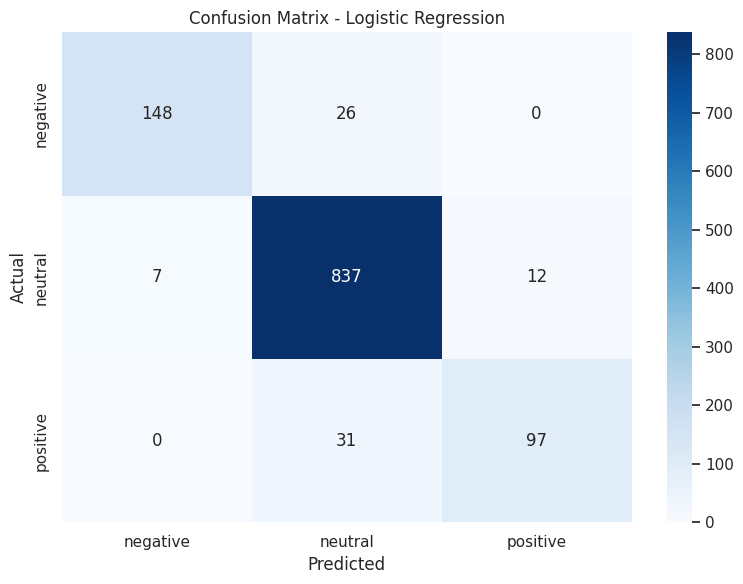

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# 1. Setup parameter grid untuk Logistic Regression
param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10, 100],            # Regularization strength
    'solver': ['liblinear', 'saga'],         # Solvers
    'max_iter': [100, 200, 500]              # Iterations
}

# 2. Setup GridSearchCV untuk mencari parameter terbaik
grid_search_logreg = GridSearchCV(LogisticRegression(), param_grid_logreg, cv=5, n_jobs=-1, verbose=1)

# 3. Fit model dengan GridSearchCV
grid_search_logreg.fit(X_train_tfidf, y_train)

# 4. Menampilkan hasil terbaik
print(f"Best parameters: {grid_search_logreg.best_params_}")
print(f"Best cross-validation score: {grid_search_logreg.best_score_}")

# 5. Evaluasi model yang sudah fine-tuned
best_logreg = grid_search_logreg.best_estimator_
y_pred_logreg_tuned = best_logreg.predict(X_test_tfidf)
print("Evaluation after tuning (Logistic Regression):")
print(classification_report(y_test, y_pred_logreg_tuned))

# Logistic Regression Confusion Matrix
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=logreg.classes_, yticklabels=logreg.classes_)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best cross-validation score: 0.9658681921662484
Evaluation after tuning (Random Forest):
              precision    recall  f1-score   support

    negative       0.94      0.94      0.94       174
     neutral       0.96      0.97      0.97       856
    positive       0.90      0.82      0.86       128

    accuracy                           0.95      1158
   macro avg       0.93      0.91      0.92      1158
weighted avg       0.95      0.95      0.95      1158



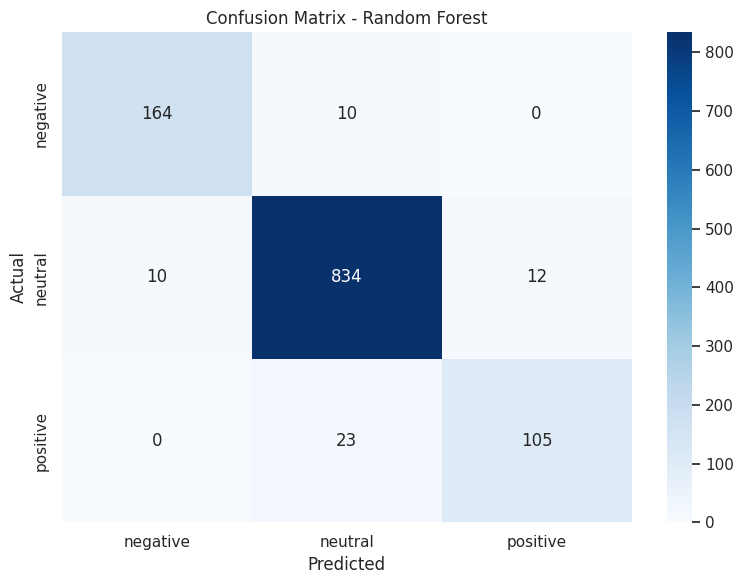

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 1. Setup parameter grid untuk Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 150],            # Jumlah pohon
    'max_depth': [None, 10, 20, 30],           # Kedalaman pohon
    'min_samples_split': [2, 5, 10],           # Jumlah minimum data untuk pemisahan
    'min_samples_leaf': [1, 2, 4],             # Jumlah minimum data di daun pohon
    'bootstrap': [True, False]                 # Penggunaan bootstrap
}

# 2. Setup GridSearchCV untuk mencari parameter terbaik
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, n_jobs=-1, verbose=1)

# 3. Fit model dengan GridSearchCV
grid_search_rf.fit(X_train_tfidf, y_train)

# 4. Menampilkan hasil terbaik
print(f"Best parameters: {grid_search_rf.best_params_}")
print(f"Best cross-validation score: {grid_search_rf.best_score_}")

# 5. Evaluasi model yang sudah fine-tuned
best_rf = grid_search_rf.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test_tfidf)
print("Evaluation after tuning (Random Forest):")
print(classification_report(y_test, y_pred_rf_tuned))

# Random Forest Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()